### Imports

In [1]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa         #library for analyzing audio and music
import librosa.display
from IPython.display import Audio
import IPython.display
from scipy.fftpack import fft
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

# 1. Download the Dataset and Understand the Format

In [2]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# google_drive = GoogleDrive(gauth)
# downloaded = google_drive.CreateFile({'id':"1v4zSFOdfbFyMFalPVB95M0atJDryKRYb"})
# downloaded.GetContentFile('Crema.zip')        
# !unzip -qq /content/Crema.zip -d /content/dataset

In [3]:
path = r"Data\Crema\\"
crema_directory = os.listdir(path)

In [4]:
emotions = []
file_path = []

In [5]:
for file in crema_directory:
  file_path.append(path + file)
  emotion = file.split('_')
  if emotion[2] == 'SAD':
      emotions.append('sad')
  elif emotion[2] == 'ANG':
      emotions.append('angry')
  elif emotion[2] == 'DIS':
      emotions.append('disgust')
  elif emotion[2] == 'FEA':
      emotions.append('fear')
  elif emotion[2] == 'HAP':
      emotions.append('happy')
  elif emotion[2] == 'NEU':
      emotions.append('neutral')
  else:
      emotions.append('unknown emotion')

In [6]:
Emotions_df = pd.DataFrame(emotions, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([path_df, Emotions_df], axis=1)
Crema_df.head()

,Path,Emotion
0,Data\Crema\\1001_DFA_ANG_XX.wav,angry
1,Data\Crema\\1001_DFA_DIS_XX.wav,disgust
2,Data\Crema\\1001_DFA_FEA_XX.wav,fear
3,Data\Crema\\1001_DFA_HAP_XX.wav,happy
4,Data\Crema\\1001_DFA_NEU_XX.wav,neutral


In [7]:
Crema_df.shape

(7442, 2)

In [8]:
def plot_waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 5))
    plt.title('Waveplot for {} emotion'.format(emotion.upper()), size=15)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()
def spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)                      # stft function converts the data into short term fourier transform, we're working in frequency domain
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 5))
    plt.title('Spectrogram for  {} emotion'.format(emotion.upper()), size=15)
    p=librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    return p
def load_audio(path):
  data, sampling_rate = librosa.load(path)
  plot_waveform(data, sampling_rate, emotion)
  p=spectrogram(data, sampling_rate, emotion)
  print(f'Sampling rate: {sampling_rate}')
  IPython.display.display(Audio(path))
  return p   

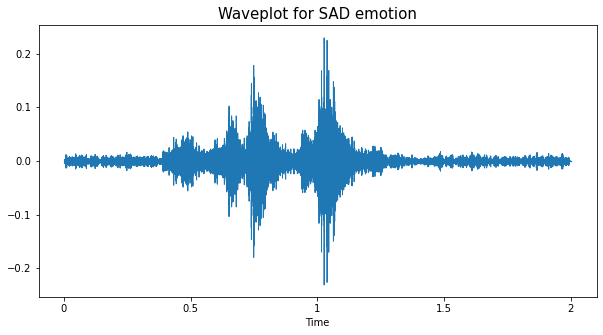

Sampling rate: 22050


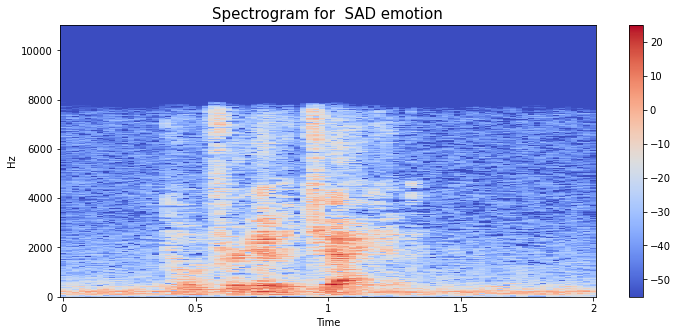

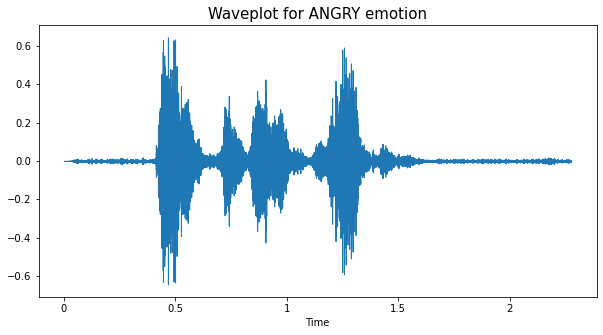

Sampling rate: 22050


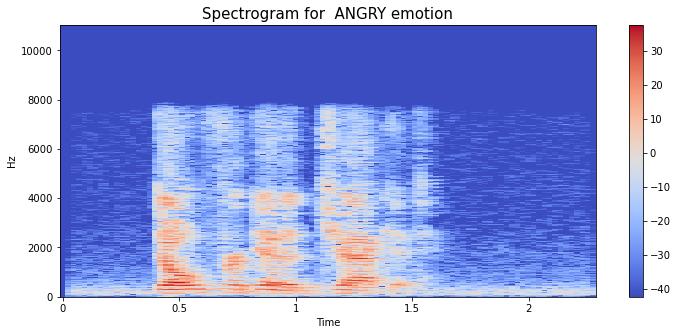

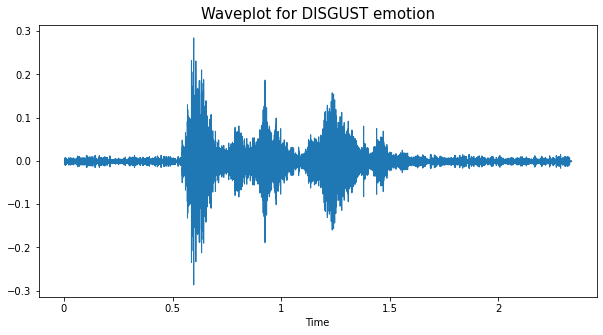

Sampling rate: 22050


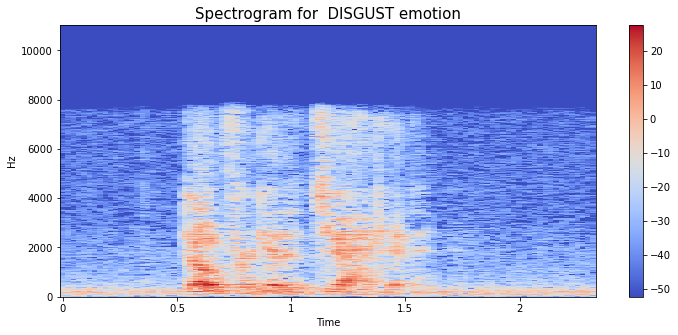

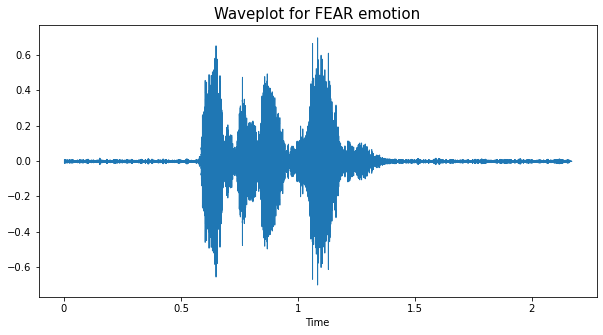

Sampling rate: 22050


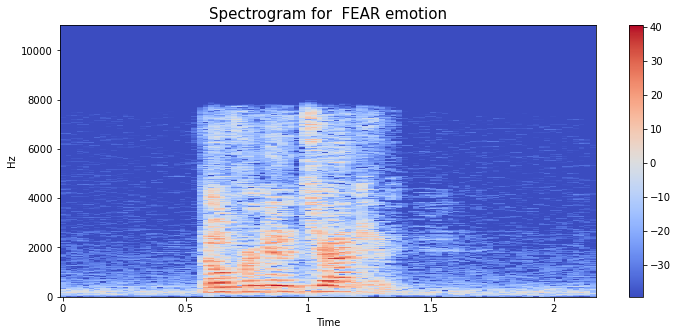

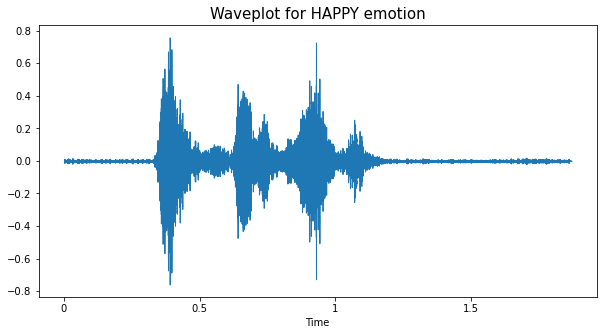

Sampling rate: 22050


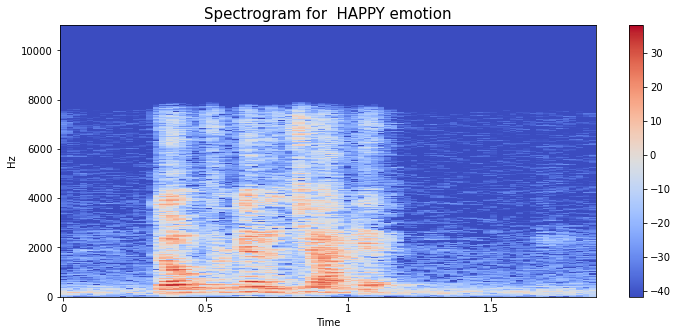

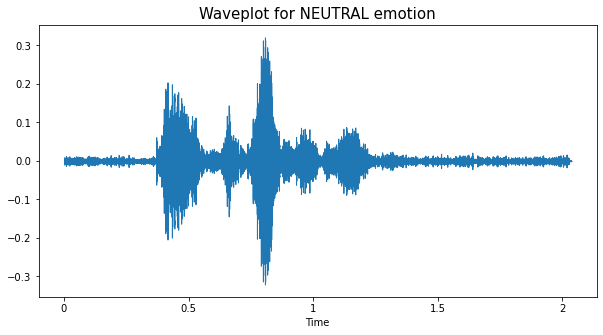

Sampling rate: 22050


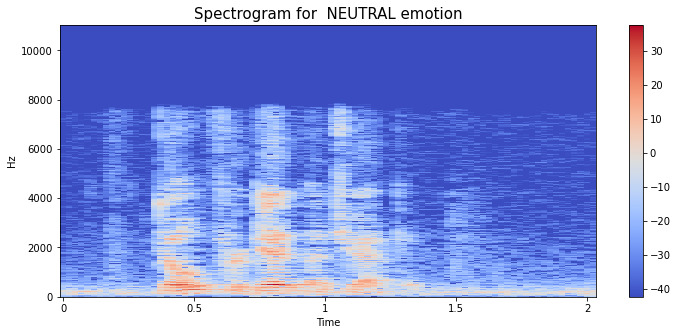

In [9]:
emotions = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
for emotion in emotions:
  path = np.array(Crema_df.Path[Crema_df.Emotion==emotion])[0]
  p=load_audio(path)
  print(p)

# 2. Create the Feature Space

In [10]:
def aduio_feature(df, feature_fn):
  features = []
  labels = []
  max_shape = (1, 1)
  for index, row in df.iterrows():
    sample, sr = librosa.load(row['Path'], sr=None)
    features.append(feature_fn(sample,))
    labels.append(row['Emotion'])
    if max_shape < features[index].shape:
      max_shape  = features[index].shape

  # Add padding to the audio feature
  for i in range(len(features)):
    padded_array = np.zeros(max_shape)
    shape = np.shape(features[i])
    padded_array[:shape[0],:shape[1]] = features[i]
    features[i] = padded_array

  return np.array(features), np.array(labels)

#### A - work on time domain or frequency domain

In [24]:
rms_features, labels = aduio_feature(Crema_df, librosa.feature.rms)

In [14]:
print(rms_features.shape)
print(labels.shape)

(7442, 1, 157)
(7442,)


In [12]:
zcr_features, labels = aduio_feature(Crema_df, librosa.feature.zero_crossing_rate)

In [15]:
print(zcr_features.shape)
print(labels.shape)

(7442, 1, 157)
(7442,)


In [22]:
time_features = np.concatenate((zcr_features, rms_features), axis=2)

In [23]:
time_features.shape

(7442, 1, 314)

#### B - Convert the audio waveform to mel spectrogram

In [32]:
spectrogram_features, labels = aduio_feature(Crema_df, librosa.feature.melspectrogram)

In [26]:
print(spectrogram_features.shape)
print(labels.shape)

(7442, 128, 157)
(7442,)


# 3. Building the Model

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

In [28]:
time_X_train_val, time_X_test, y_train_val, y_test = train_test_split(time_features, labels, test_size=0.30, random_state=42)
time_X_train, time_X_val, y_train, y_val = train_test_split(time_X_train_val, y_train_val, test_size=0.05, random_state=42)


In [29]:
print(time_X_train.shape)
print(time_X_test.shape)
print(time_X_val.shape)

(4948, 1, 314)
(2233, 1, 314)
(261, 1, 314)


In [30]:
spectrogram_X_train_val, spectrogram_X_test, y_train_val, y_test = train_test_split(spectrogram_features, labels, test_size=0.30, random_state=42)
spectrogram_X_train, spectrogram_X_val, y_train, y_val = train_test_split(spectrogram_X_train_val, y_train_val, test_size=0.05, random_state=42)

In [31]:
print(spectrogram_X_train.shape)
print(spectrogram_X_test.shape)
print(spectrogram_X_val.shape)

(4948, 128, 157)
(2233, 128, 157)
(261, 128, 157)


# 4. Big Picture